# cluster COVID-19 new case trends

Use the conda package `tslearn` to cluster trends in new cases of COVID-19 across US states.

## import libraries

In [1]:
# numerical libraries
import numpy as np
import scipy as sp
import pystan

# pandas!
import pandas as pd

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## load `tslearn` functions

In [2]:
from tslearn.clustering import TimeSeriesKMeans

/home/ruchbah/miniconda3/envs/covid_dev/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ruchbah/miniconda3/envs/covid_dev/lib/python3.8/site-packages/tslearn/bases.py:14: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## load trend data

In [20]:
# import data
trends_df = pd.read_csv('covid_state_localleveltrend_today.csv')

# nice dates
trends_df['date'] = pd.to_datetime(trends_df['date'])

# pivot
trends_pivot = trends_df.pivot(index='date',columns='state',values='trend')

# there are a couple of days with missing data
trends_pivot = trends_pivot.interpolate()

# standardize trend values
trends_pivot_std = (trends_pivot - np.mean(trends_pivot)) / np.std(trends_pivot)

# unstack and clean up
trends_std_df = pd.DataFrame(trends_pivot_std.stack().reset_index())
trends_std_df.rename(columns={0:'trend_std'},inplace=True)

In [21]:
# get a nice list of states
stt_lst = sort(list(set(trends_df['state'])))

## make an array for `tslearn`

In [22]:
X = np.array(trends_pivot_std).T

In [23]:
# should be number of states by number of time periods
X.shape

(55, 89)

## apply Time Series KMeans

In [24]:
# let's try with 3 clusters
# do some restarts because after all this shit is kmeans
# even if it has a fancy distance metric
km = TimeSeriesKMeans(n_clusters=3,n_init=10,max_iter=100,metric="dtw")

In [25]:
# apply kmeans model
labels = km.fit_predict(X)

In [26]:
# make an interpretable label dictionary
labels_dict = {}

for i in range(len(stt_lst)):
    labels_dict[stt_lst[i]] = labels[i]

In [27]:
# map cluster names to the data
trends_std_df['ts_cluster'] = trends_std_df['state'].map(labels_dict)

In [28]:
# what's the average standardized trend value by time period by cluster
tsc_trends = trends_std_df.groupby(['date','ts_cluster']).mean()['trend_std'].reset_index()

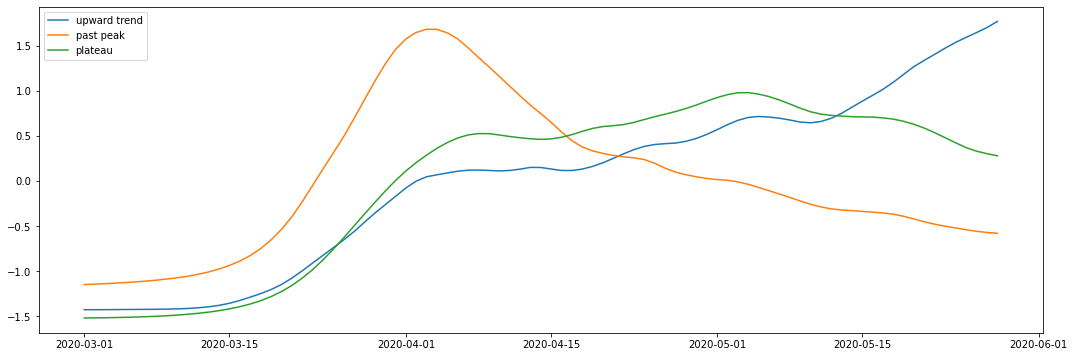

In [32]:
plt.figure(figsize=(18,6))
for i in range(max(labels)+1):
    plt.plot(tsc_trends[tsc_trends.ts_cluster == i]['date'],
             tsc_trends[tsc_trends.ts_cluster == i]['trend_std'],
             label=labels_clever_name[i]
            )
    
plt.legend();

In [33]:
# give clusters clever names
# assume you have to check that these names make sense,
# because no guarantees these won't re-order/change
# each time you run the algorithm
labels_clever_name = {0:'upward trend',1:'past peak',2:'plateau'}

# map to dataframe
trends_std_df['ts_cluster_name'] = trends_std_df['ts_cluster'].map(labels_clever_name)

In [34]:
labels_count = {'upward trend':0,'past peak':0,'plateau':0}

for s in labels_dict:
    if labels_dict[s] == 0:
        labels_count['upward trend'] += 1
    elif labels_dict[s] == 1:
        labels_count['past peak'] += 1
    else:
        labels_count['plateau'] += 1

# ouch!
labels_count

{'upward trend': 14, 'past peak': 14, 'plateau': 27}

In [35]:
# merge trends in levels back to standardized and cluster names
trends_with_labels = trends_std_df.merge(trends_df[['state', 'date', 'trend']],
                                         left_on=['state','date'],
                                         right_on=['state','date'],
                                         how='left')

# sort by state, date
trends_with_labels = trends_with_labels.sort_values(['state', 'date']).reset_index()

# clean up columns
trends_with_labels = trends_with_labels[['state', 'date', 'trend','trend_std','ts_cluster','ts_cluster_name']]

# interpolate missing values of trend
trends_with_labels['trend'] = trends_with_labels['trend'].interpolate()

In [36]:
trends_with_labels.head(10)

,state,date,trend,trend_std,ts_cluster,ts_cluster_name
0,Alabama,2020-03-01,0.029802,-1.410633,0,upward trend
1,Alabama,2020-03-02,0.016061,-1.410744,0,upward trend
2,Alabama,2020-03-03,-0.002504,-1.410894,0,upward trend
3,Alabama,2020-03-04,-0.028840,-1.411107,0,upward trend
4,Alabama,2020-03-05,-0.057099,-1.411335,0,upward trend
5,Alabama,2020-03-06,-0.076005,-1.411488,0,upward trend
6,Alabama,2020-03-07,-0.064075,-1.411392,0,upward trend
7,Alabama,2020-03-08,-0.016952,-1.411011,0,upward trend
8,Alabama,2020-03-09,0.080793,-1.410222,0,upward trend
9,Alabama,2020-03-10,0.256932,-1.408799,0,upward trend


In [37]:
trends_with_labels.to_csv('covid_state_locallevel_trend_tscluster_today.csv')